# Exemple de test Keras pour la génération d’images de visages CelebA avec un DCGAN


In [1]:
import keras
import tensorflow as tf
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import glob
from PIL import Image

## 1. Prepare CelebA data


In [2]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [3]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files.


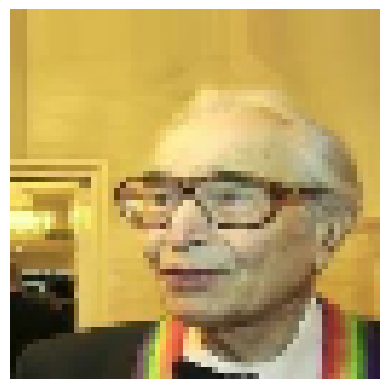

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## 2. Create the discriminator

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Create the generator

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Override train_step

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## 5. Create a callback that periodically saves generated images

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## 6. Train the end-to-end model


In [8]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1737s 270ms/step - d_loss: 0.5716 - g_loss: 1.3981


## 7. Afficher toutes les images générée

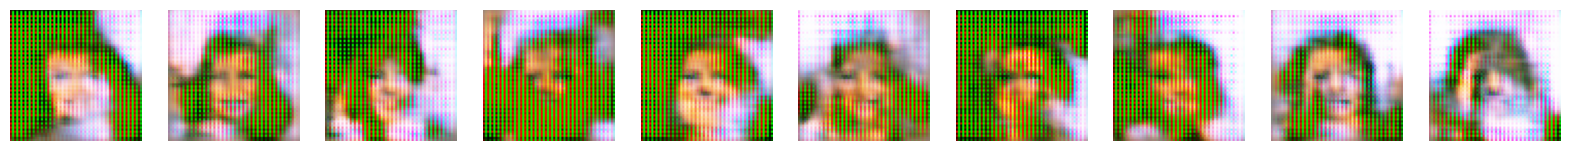

In [10]:
generated_images_paths = sorted(glob.glob("generated_img_*.png"))
plt.figure(figsize=(20, 5))
for i, img_path in enumerate(generated_images_paths):
    img = Image.open(img_path)
    plt.subplot(2, len(generated_images_paths), i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

# TP : Génération de chiffres MNIST avec un GAN

# 1. Importations

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# 2. Chargement des données MNIST

In [12]:
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# 3. Preparation des données

## 3.1 Normalisation dans [0,1]

In [13]:
x_train = x_train.astype("float32") / 255.0

## 3.2 Redimensionner de 28x28 à 64x64 pour compatibilité DCGAN

In [14]:
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, (64, 64))

## 3.3 Conversion en RGB de (64,64,1) à (64,64,3)

In [15]:
x_train = tf.image.grayscale_to_rgb(x_train)

In [ ]:
print("Shape :", x_train.shape)

Shape : (60000, 64, 64, 3)


In [ ]:
print("Pixel min:", x_train.numpy().min(), "pixel max:", x_train.numpy().max())

Pixel min: 0.0 pixel max: 1.0


## 3.4 Création du dataset TensorFlow

In [16]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# 4. Analyse exploratoire

## 4.1 Visualisation d’un échantillon

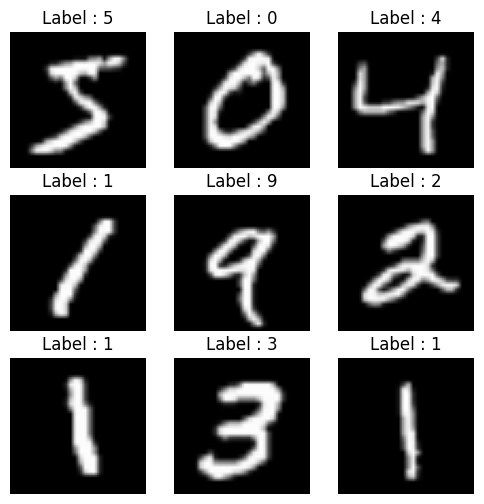

In [ ]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label : {y_train[i]}")
    plt.axis("off")
plt.show()

## 4.2 Distribution des classes

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Distribution des classes MNIST :")
for k,v in class_counts.items():
    print(f"Classe {k} : {v} images")

Distribution des classes MNIST :
Classe 0 : 5923 images
Classe 1 : 6742 images
Classe 2 : 5958 images
Classe 3 : 6131 images
Classe 4 : 5842 images
Classe 5 : 5421 images
Classe 6 : 5918 images
Classe 7 : 6265 images
Classe 8 : 5851 images
Classe 9 : 5949 images


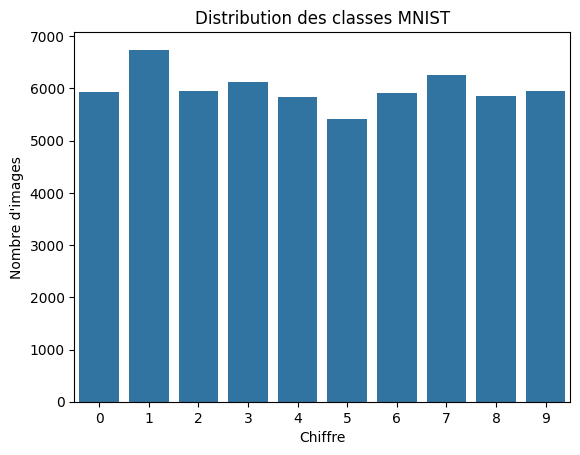

In [ ]:
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribution des classes MNIST")
plt.xlabel("Chiffre")
plt.ylabel("Nombre d'images")
plt.show()

Cette sortie nous montre que chaque chiffre de 0 à 9 est représenté par plusieurs milliers d’images et que le dataset est assez équilibré, donc le générateur aura toutes les classes à apprendre.

## 4.3 Vérification générale après prétraitement

In [ ]:
print("Type dataset :", type(x_train))
print("Shape dataset :", x_train.shape)
print("Min pixel :", tf.reduce_min(x_train).numpy())
print("Max pixel :", tf.reduce_max(x_train).numpy())
print("Nombre de classes :", len(np.unique(y_train)))

Type dataset : <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape dataset : (60000, 64, 64, 3)
Min pixel : 0.0
Max pixel : 1.0
Nombre de classes : 10


# 5. Architecture DCGAN

In [17]:
latent_dim = 128

## 5.1 Générateur

**Le générateur** est un réseau de neurones qui prend en entrée un vecteur latent aléatoire et produit des images synthétiques. Son rôle est de créer des images réalistes capables de tromper le discriminateur.

In [18]:
generator = keras.Sequential([
keras.Input(shape=(latent_dim,)),

# Redimensionnée en carte 8×8×128
layers.Dense(8*8*128),
layers.Reshape((8, 8, 128)),

# Upsampling de 8x8 à 16x16
layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(0.2),

# de 16x16 à 32x32
layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(0.2),

# de 32x32 à 64x64
layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
layers.BatchNormalization(),
layers.LeakyReLU(0.2),

# Image finale RGB 64x64x3
layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid")
], name="generator")

generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,235 (15.19 MB)

 Trainable params: 3,981,443 (15.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 5.2 Discriminateur

**Le discriminateur** est un réseau qui prend une image en entrée et prédit si elle est réelle ou générée. Son rôle est de distinguer le vrai du faux et de guider le générateur à s’améliorer.

In [19]:
discriminator = keras.Sequential([
    keras.Input(shape=(64,64,3)),

    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),

    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),

    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="discriminator")

discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## 5.3 Implémentation du modèle GAN

In [20]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Phase Discriminateur
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.zeros((batch_size,1)), tf.ones((batch_size,1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        #  Phase Générateur
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size,1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Mise à jour des métriques
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## 5.4 Callback pour monitoring

**Le callback** est une fonction exécutée pendant l’entraînement, ici à la fin de chaque époque. Son rôle est de générer et afficher des images synthétiques pour visualiser la progression qualitative du générateur.

### Affichage des images générées par époque.

In [21]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images.numpy()

        plt.figure(figsize=(10,2))
        for i in range(self.num_img):
            plt.subplot(1,self.num_img,i+1)
            plt.imshow(generated_images[i])
            plt.axis("off")
        plt.show()

### Suivi des pertes.

In [22]:
class GANMonitorWithLoss(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.d_losses = []
        self.g_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.d_losses.append(logs["d_loss"])
        self.g_losses.append(logs["g_loss"])
        print(f"Epoch {epoch+1}: d_loss={logs['d_loss']:.4f}, g_loss={logs['g_loss']:.4f}")

## 5.5 Entraînement du GAN

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - d_loss: 3415.5247 - g_loss: 2.8010

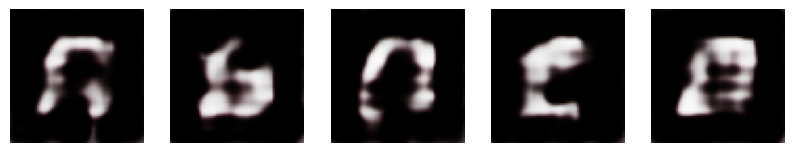

Epoch 1: d_loss=1841.7112, g_loss=1.9914
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 523s 267ms/step - d_loss: 3414.6855 - g_loss: 2.8006
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 29.0733 - g_loss: 4.5044

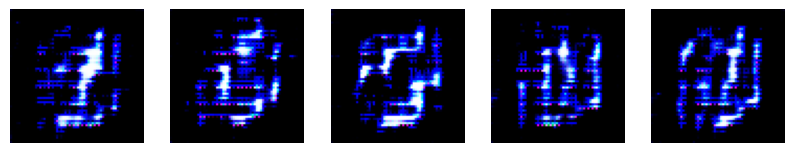

Epoch 2: d_loss=16.4375, g_loss=4.0788
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 270ms/step - d_loss: 29.0665 - g_loss: 4.5041
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 4.8361 - g_loss: 3.4643

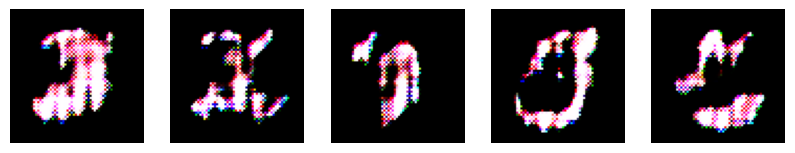

Epoch 3: d_loss=3.9038, g_loss=3.4956
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 506s 270ms/step - d_loss: 4.8356 - g_loss: 3.4643
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 1.3224 - g_loss: 1.0133

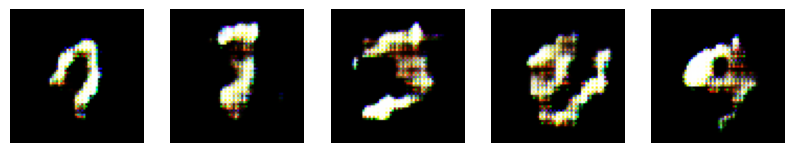

Epoch 4: d_loss=1.2000, g_loss=1.0519
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 506s 270ms/step - d_loss: 1.3224 - g_loss: 1.0133
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 1.0180 - g_loss: 1.5957

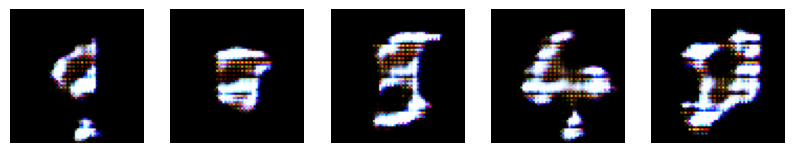

Epoch 5: d_loss=0.9909, g_loss=1.6081
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 270ms/step - d_loss: 1.0180 - g_loss: 1.5957
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.8606 - g_loss: 1.4026

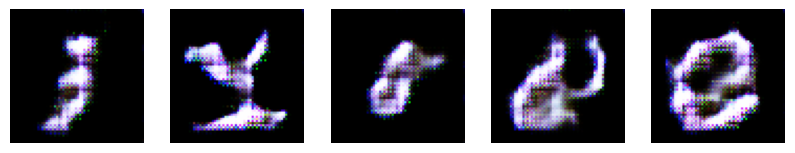

Epoch 6: d_loss=0.8426, g_loss=1.4318
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 271ms/step - d_loss: 0.8606 - g_loss: 1.4026
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.7457 - g_loss: 1.2875

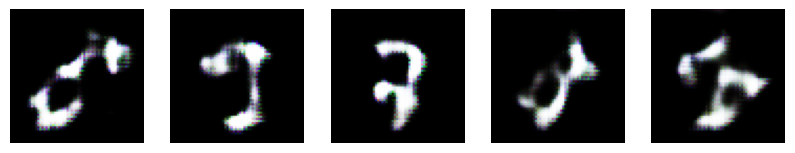

Epoch 7: d_loss=0.7259, g_loss=1.2113
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 271ms/step - d_loss: 0.7457 - g_loss: 1.2875
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.6668 - g_loss: 0.9368

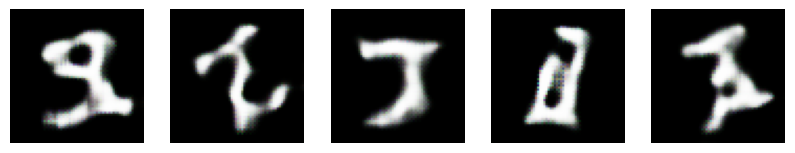

Epoch 8: d_loss=0.6532, g_loss=0.8939
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 271ms/step - d_loss: 0.6668 - g_loss: 0.9368
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.6658 - g_loss: 0.8200

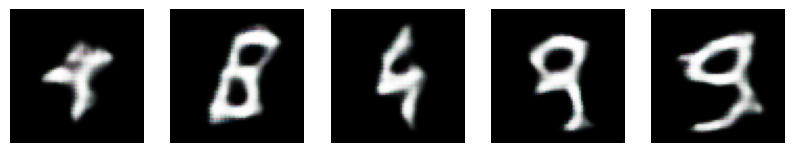

Epoch 9: d_loss=0.6568, g_loss=0.8190
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 271ms/step - d_loss: 0.6658 - g_loss: 0.8200
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.6732 - g_loss: 0.7622

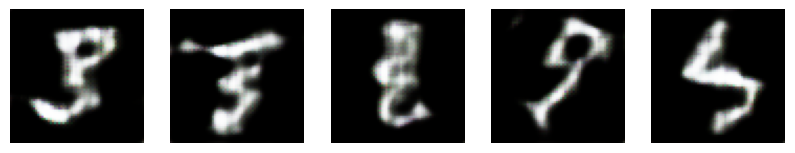

Epoch 10: d_loss=0.6696, g_loss=0.7540
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 271ms/step - d_loss: 0.6732 - g_loss: 0.7621
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.6641 - g_loss: 0.7560

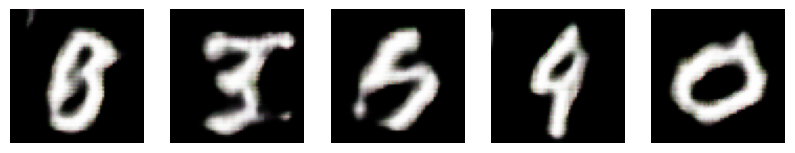

Epoch 11: d_loss=0.6620, g_loss=0.7514
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 271ms/step - d_loss: 0.6641 - g_loss: 0.7560
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.6363 - g_loss: 0.8075

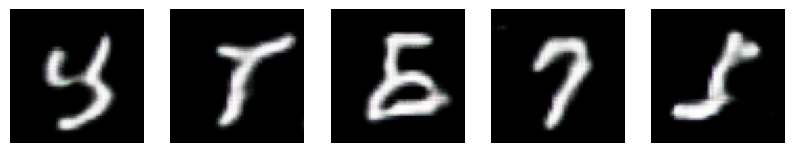

Epoch 12: d_loss=0.6215, g_loss=0.8301
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 271ms/step - d_loss: 0.6363 - g_loss: 0.8075
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.6297 - g_loss: 0.8298

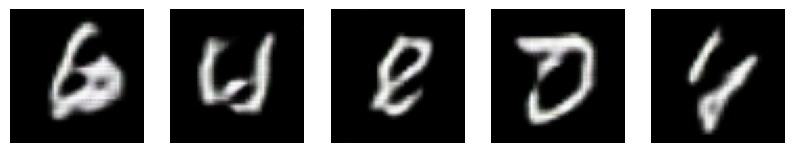

Epoch 13: d_loss=0.6245, g_loss=0.8205
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 271ms/step - d_loss: 0.6297 - g_loss: 0.8298
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 0.6013 - g_loss: 0.8656

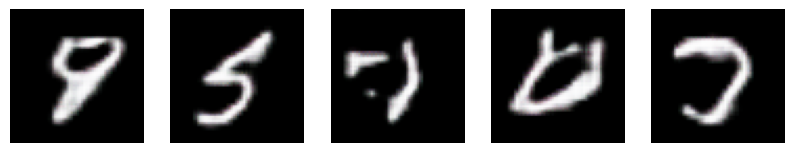

Epoch 14: d_loss=0.5955, g_loss=0.8722
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 270ms/step - d_loss: 0.6013 - g_loss: 0.8656
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_loss: 0.5802 - g_loss: 0.9103

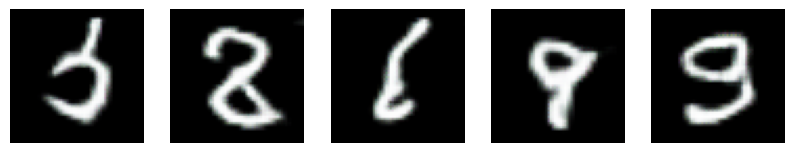

Epoch 15: d_loss=0.5772, g_loss=0.9212
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 271ms/step - d_loss: 0.5802 - g_loss: 0.9103
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 0.5665 - g_loss: 0.9505

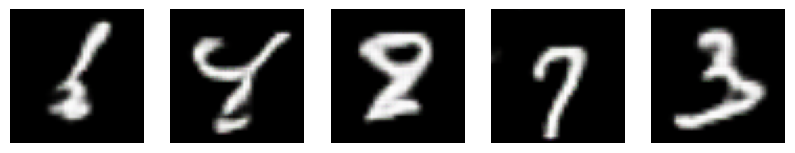

Epoch 16: d_loss=0.5649, g_loss=0.9563
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 270ms/step - d_loss: 0.5665 - g_loss: 0.9505
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 0.5585 - g_loss: 0.9652

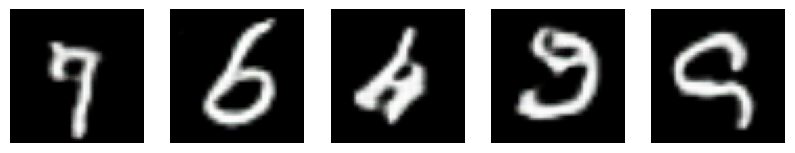

Epoch 17: d_loss=0.5549, g_loss=0.9869
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 270ms/step - d_loss: 0.5585 - g_loss: 0.9653
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 0.5487 - g_loss: 1.0061

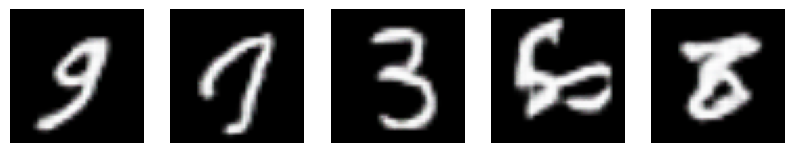

Epoch 18: d_loss=0.5473, g_loss=1.0201
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 506s 270ms/step - d_loss: 0.5487 - g_loss: 1.0061
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 0.5406 - g_loss: 1.0252

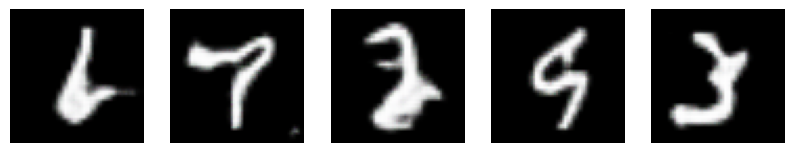

Epoch 19: d_loss=0.5369, g_loss=1.0398
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 506s 270ms/step - d_loss: 0.5406 - g_loss: 1.0252
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_loss: 0.5314 - g_loss: 1.0816

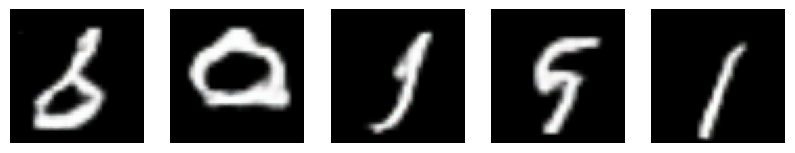

Epoch 20: d_loss=0.5270, g_loss=1.0778
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 506s 270ms/step - d_loss: 0.5314 - g_loss: 1.0816


In [ ]:
gan = GAN(discriminator, generator, latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(0.0001),
    g_optimizer=keras.optimizers.Adam(0.0001),
    loss_fn=keras.losses.BinaryCrossentropy()
)

monitor_loss = GANMonitorWithLoss()
gan.fit(dataset, epochs=20, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim), monitor_loss])


### Courbes d'évolution des pertes

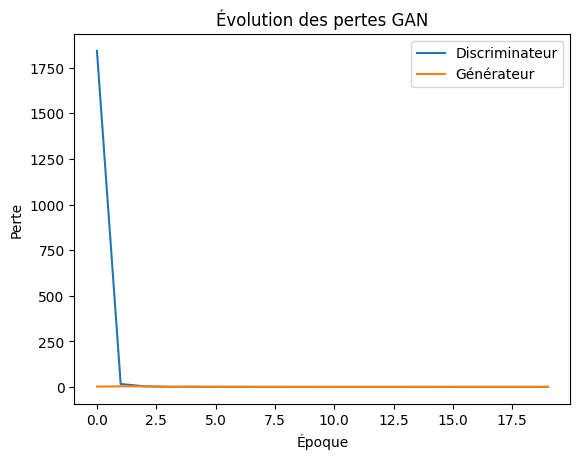

In [ ]:
plt.plot(monitor_loss.d_losses, label="Discriminateur")
plt.plot(monitor_loss.g_losses, label="Générateur")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Évolution des pertes GAN")
plt.legend()
plt.show()

Le graphique montre un gros pic de perte du discriminateur au tout début, dû à l’initialisation aléatoire des poids. Dès la première époque, cette perte chute fortement car le discriminateur apprend rapidement à distinguer les vraies images du bruit produit par le générateur. Par la suite, les deux courbes restent très basses et assez stables.

## 5.6 Génération finale de chiffres

### Génération de 10 images aléatoires

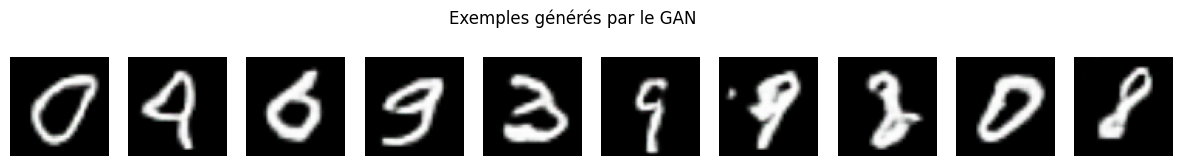

In [ ]:
random_latent_vectors = tf.random.normal(shape=(10, latent_dim))
generated_images = gan.generator(random_latent_vectors)
generated_images = generated_images.numpy()

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.suptitle("Exemples générés par le GAN")
plt.show()

Cette grille de 10 images présente un échantillon aléatoire produit par le générateur après 20 époques d'entraînement. Chaque image est le résultat de la transformation d'un vecteur de bruit aléatoire (tiré d'une distribution normale dans l'espace latent de dimension 128) par le réseau de neurones générateur.

### Génération de 20 images aléatoires

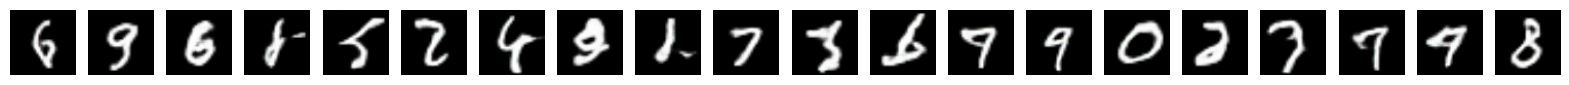

In [ ]:
random_latent_vectors = tf.random.normal(shape=(20, latent_dim))
generated_images = gan.generator(random_latent_vectors).numpy()

plt.figure(figsize=(20,2))
for i in range(20):
    plt.subplot(1,20,i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.show()


**Les images générées présentent :**

* Des formes globalement similaires à des chiffres manuscrits, ce qui indique que le générateur a appris la structure globale des données.
* Une structure reconnaissable pour certains chiffres tels que 0, 3, 4, 5, 6, 8 et 9, qui se rapprochent visuellement des exemples réels.
 * Cependant, certains chiffres apparaissent flous, déformés ou incomplets, traduisant un manque de détails fins et une précision encore limitée dans la génération.

## 5.7 Comparaison images réelles vs générées


In [ ]:
def comparaison_reel_genere(real_images, generated_images):
    plt.figure(figsize=(12,4))

    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(real_images[i])
        plt.title("Réelle")
        plt.axis("off")

    for i in range(10):
        plt.subplot(2,10,10+i+1)
        plt.imshow(generated_images[i])
        plt.title("Générée")
        plt.axis("off")

    plt.show()


### Prendre 10 images réelles

In [ ]:
real_images = x_train[:10].numpy()

### Générer 10 images

In [ ]:
latent_vectors = tf.random.normal(shape=(10, latent_dim))
generated_10 = gan.generator(latent_vectors).numpy()

### Comparaison

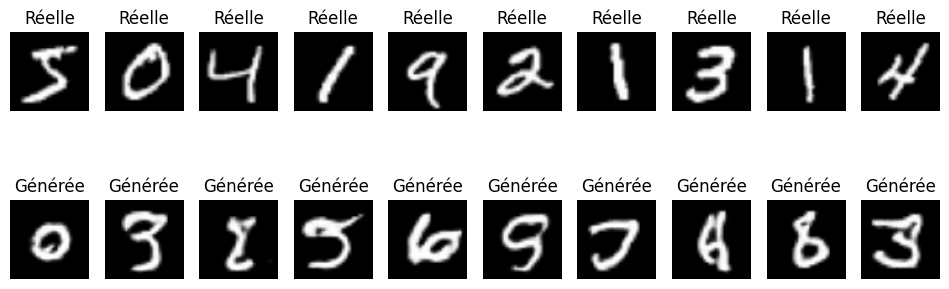

In [ ]:
comparaison_reel_genere(real_images, generated_10)

Les images réelles montrent :
* Des chiffres bien définis et lisibles.
* Une structure cohérente avec le style manuscrit du dataset MNIST.
* Un bon contraste entre le fond noir et le chiffre blanc.
* Une diversité de formes correspondant à différents styles d’écriture.

Les résultats montrent que le GAN parvient à générer des chiffres globalement similaires à ceux du dataset MNIST, avec certaines formes reconnaissables. Toutefois, la présence de flou et de déformations indique que le modèle est encore en phase d’apprentissage et n’a pas atteint une convergence optimale. Une augmentation du nombre d’epochs car 20 est insuffisant pour une stabilisation complète et un ajustement des hyperparamètres permettraient d’améliorer la qualité des images générées.



## 5.8 Évaluation de la diversité


In [ ]:
def afficher_diversite(generated_images, n=50):
    plt.figure(figsize=(15,15))
    for i in range(n):
        plt.subplot(10,5,i+1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.show()


### Générer 50 images pour évaluer diversité


In [ ]:
latent_vectors = tf.random.normal(shape=(50, latent_dim))
generated_50 = gan.generator(latent_vectors).numpy()

### Affichage de diversité

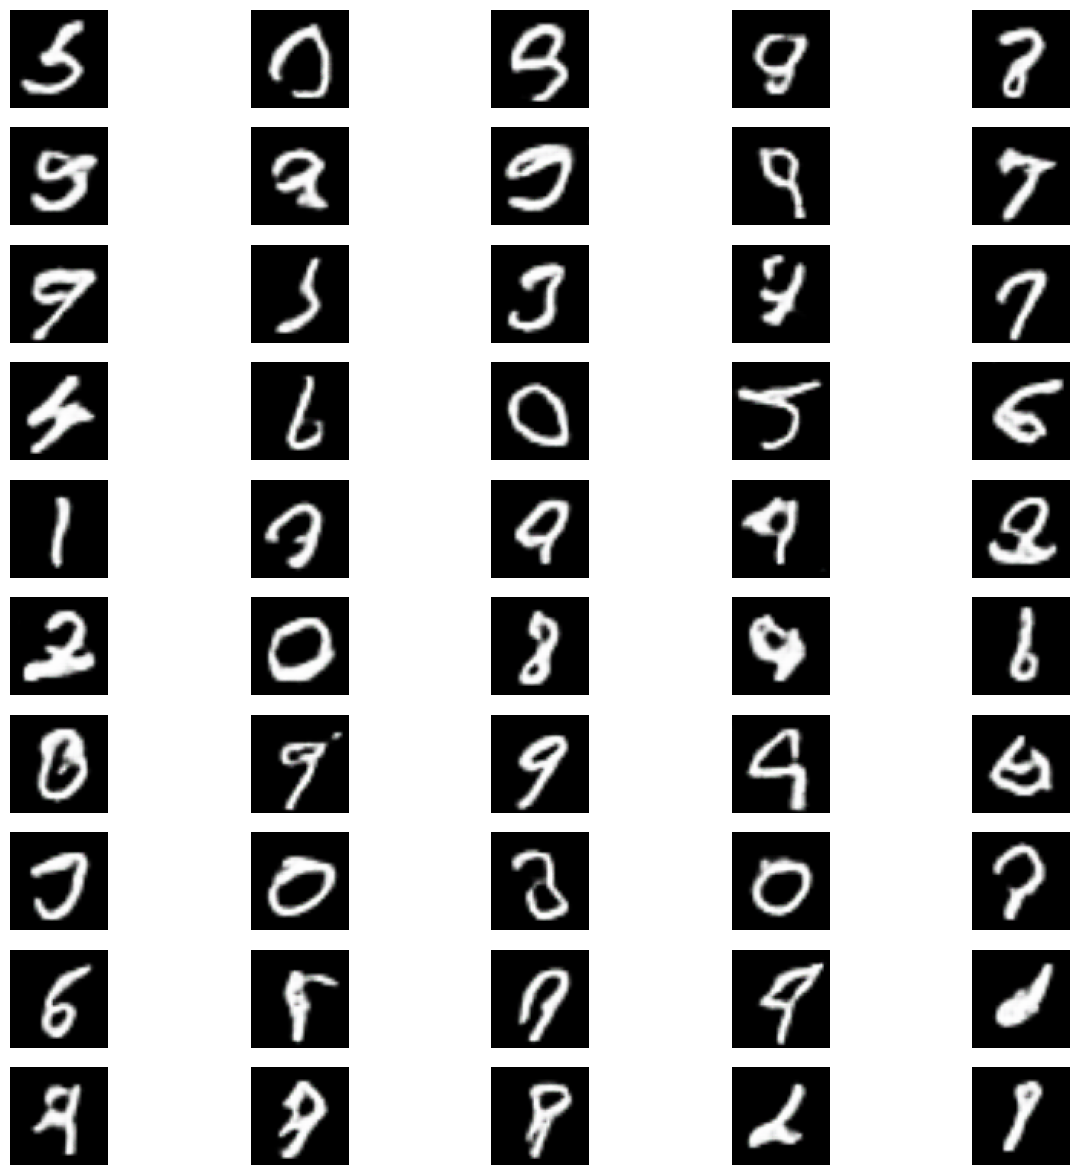

In [ ]:
afficher_diversite(generated_50, n=50)

**1. Absence de mode collapse (effondrement de mode)**
Les chiffres générés sont variés (0, 1, 3, 5, 8, 9…) et présentent des styles différents.  

Le générateur ne se contente pas de répéter un seul chiffre. Il exploite correctement l’espace latent et reproduit la diversité du dataset MNIST, ce qui montre qu’il n’y a pas de mode collapse.

**2. Qualité des images et artefacts**

La plupart des chiffres sont reconnaissables, mais certains sont flous, déformés ou incomplets.

Ces défauts viennent de l’upsampling via les couches Conv2DTranspose et du passage de 28×28 à 64×64, qui force le modèle à inventer des détails. Cela peut provoquer des contours irréguliers ou des épaisseurs artificielles.

**3. Interpolation dans l’espace latent**

Certains chiffres semblent hybrides ou ambigus (ex. mélange entre 7 et 9).

Le générateur apprend une représentation continue des chiffres. Lorsque le vecteur latent se situe entre deux classes, le modèle produit une interpolation. Cela montre qu’il a appris des **caractéristiques abstraites** plutôt que de mémoriser les images d’origine.



## 6. Augmentation de nombre d’epochs à 50 et ajustement des learning rates

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - d_loss: 12.3066 - g_loss: 1.0580

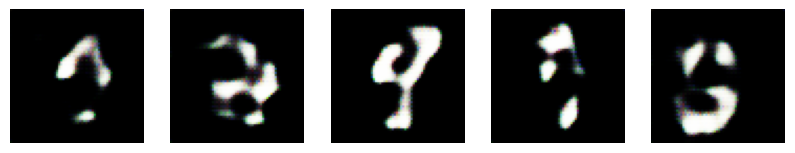

Epoch 1: d_loss=4.2046, g_loss=0.8549
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 515s 268ms/step - d_loss: 12.3023 - g_loss: 1.0579
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.6990 - g_loss: 0.7311

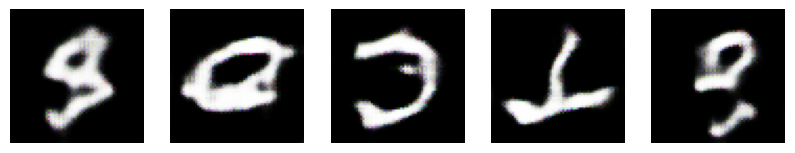

Epoch 2: d_loss=0.6926, g_loss=0.7250
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 267ms/step - d_loss: 0.6990 - g_loss: 0.7311
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.6910 - g_loss: 0.6857

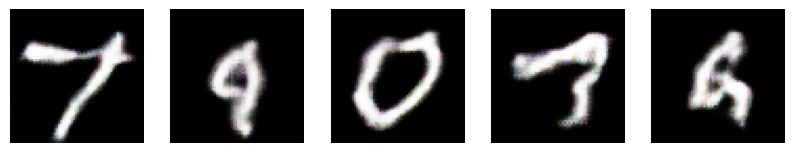

Epoch 3: d_loss=0.6898, g_loss=0.6806
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 500s 267ms/step - d_loss: 0.6910 - g_loss: 0.6857
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.6864 - g_loss: 0.6761

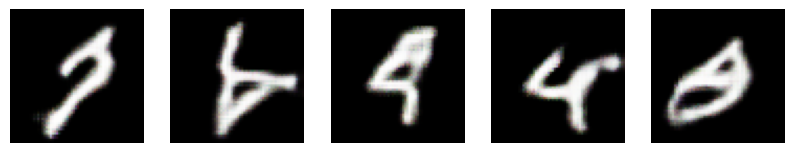

Epoch 4: d_loss=0.6833, g_loss=0.6768
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 267ms/step - d_loss: 0.6864 - g_loss: 0.6761
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - d_loss: 0.6765 - g_loss: 0.6907

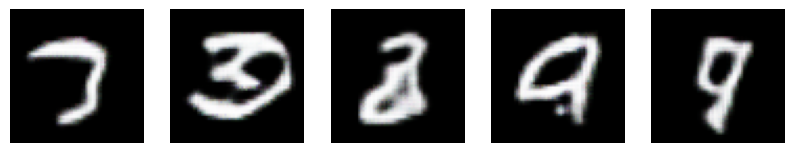

Epoch 5: d_loss=0.6741, g_loss=0.6950
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 502s 268ms/step - d_loss: 0.6765 - g_loss: 0.6907
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - d_loss: 0.6499 - g_loss: 0.7440

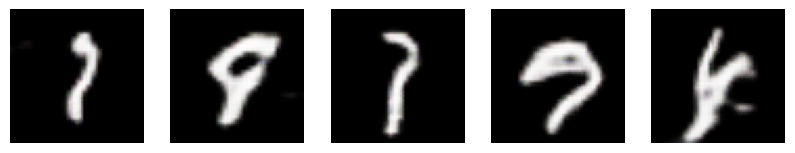

Epoch 6: d_loss=0.6249, g_loss=0.8020
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 503s 268ms/step - d_loss: 0.6499 - g_loss: 0.7441
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.5208 - g_loss: 1.0506

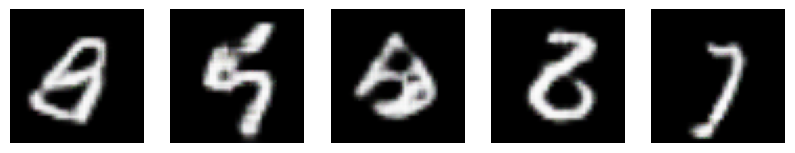

Epoch 7: d_loss=0.4843, g_loss=1.1509
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 267ms/step - d_loss: 0.5208 - g_loss: 1.0506
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.3859 - g_loss: 1.4818

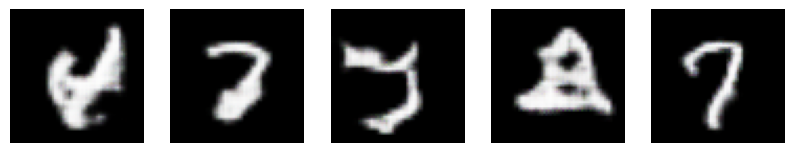

Epoch 8: d_loss=0.3568, g_loss=1.5989
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 267ms/step - d_loss: 0.3859 - g_loss: 1.4818
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.2847 - g_loss: 1.9483

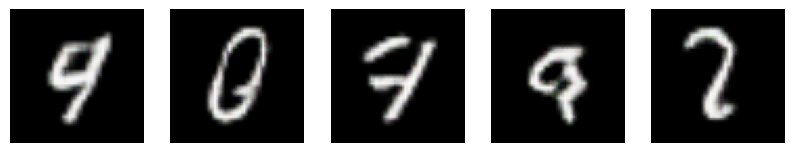

Epoch 9: d_loss=0.2665, g_loss=2.0539
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 500s 267ms/step - d_loss: 0.2847 - g_loss: 1.9483
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_loss: 0.2277 - g_loss: 2.3638

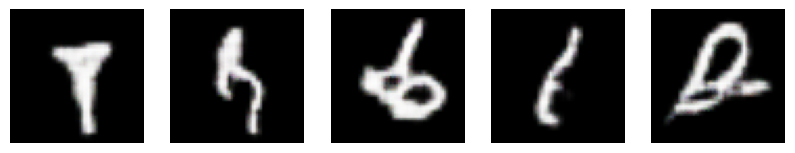

Epoch 10: d_loss=0.2090, g_loss=2.4651
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 267ms/step - d_loss: 0.2276 - g_loss: 2.3638
Epoch 11/50
 237/1875 ━━━━━━━━━━━━━━━━━━━━ 7:18 268ms/step - d_loss: 0.1631 - g_loss: 2.6813

In [ ]:
gan = GAN(discriminator, generator, latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)
monitor_loss = GANMonitorWithLoss()
gan.fit(dataset, epochs=50, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim), monitor_loss])


# Conclusion

Ce TP démontre l’efficacité des GANs pour la génération d’images et met en évidence le principe fondamental de l’apprentissage adversarial. Le modèle proposé constitue une base fonctionnelle pouvant être améliorée pour produire des images plus nettes et plus réalistes.